# Modellépítés: Terroresemények időfüggetlen klaszterezése

A terroreseményeket több algoritmus segítségével is klasztereztük az a eseményekben rejlő mintázatok, hasonlóságok kinyerése végett. A 3 alkalmazott módszer a `KMeans`, a `DBSCAN` és a `Dask Spectral Clustering` algoritmusok voltak.

A modell során több dependenciát használunk, ezeket a követekező 2 cella installál és importálja.

In [ ]:
# Dependeciák telepítése
!pip3 install pandas
!pip3 install openpyxl
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install tqdm
!pip3 install dask-ml

In [122]:
# Dependeciák importálása
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from dask_ml.cluster import SpectralClustering
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Előfeldolgozás
### Adatkeret beolvasása

Az adatkeret `.xlsx` formátumban áll rendelkezésre. Ennek importálására a *pandas*nak beépíttett függvénye van. A *dask* ilyennel nem rendelkezik. Emellett az adatkeret $209706$ rekordból áll. Ez a memóriában elfér, így az adatmanipulációhoz ebben a lépésben is a *pandas*-t használtuk a teljes adatkereten dolgozva.

In [107]:
# Adatok importálása /időigényes cella!/
df_gtd = pd.read_excel('globalterrorismdb_0522dist.xlsx')

In [109]:
df_gtd.shape

(209706, 135)

### Feature és sample szűrés

A beolvasott adatokon 2 dimezióban szűrést végeztünk a követekező szempontok szerint:
* A klaszterezésben fő szerepet fog játszani a földrajzi helye a terroreseménynek, azonban vannak olyan események, melyekhez pontos (földrajzi koordináta szerinti) helyszín nem elérhető. Ebben az esetben 2 lehetőségünk lenne.  
    * Az hiányzó adatokat imputálhatnánk az elérhető helyinformáció alapján, ez azonban meglehetősen pontatlan eredményekkel is szolgálhat (pl. csak országszintű információ van). 
    * A másik lehetőség a hiányzó sorok elhagyása. Mivel ezek számossága csak $4000$ (lásd alább), mely nagyságrendekkel kisebb az adatkeret sorainak számánál, ezért ezt a kézenfekvő opciót választottuk.
* A többi hiányos oszlopot imputációs stratégia hiányában elhagyjuk.
* A klaszterezés időfüggetlen, így az időre vonatkozó feature-ök is kikerülnek a modellépítésből.
* A klaszterezés szempontjából lényegtelennek tekintjük, hogy az adatgyűjtés melyik adatbázisból, melyik szervezet által került begyűjtésre.
* A szöveges adatokra a későbbiekben nem lesz szükségünk, valamint inkompatibilitást is okoz egyes előfeldolgozó műveletekben, így ezektől is eltekintünk.

In [110]:
print("A nem elérhető koordinátájú sorok száma: {}".format(len(df_gtd[df_gtd['latitude'].isna() | df_gtd['longitude'].isna()])))
df_gtd_reduced = df_gtd[df_gtd['latitude'].notna() & df_gtd['longitude'].notna()]
df_gtd_reduced = df_gtd_reduced.dropna(axis=1)
df_gtd_reduced = df_gtd_reduced.drop(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'dbsource', 'provstate', 'gname'], axis=1)
df_gtd_reduced = df_gtd_reduced[df_gtd_reduced.columns.drop(list(df_gtd_reduced.filter(regex='_txt')))]


df_gtd_reduced.describe

A nem elérhető koordinátájú sorok száma: 4692


<bound method NDFrame.describe of         country  region   latitude   longitude  specificity  vicinity  crit1  \
0            58       2  18.456792  -69.951164          1.0         0      1   
1           130       1  19.371887  -99.086624          1.0         0      1   
2           160       5  15.478598  120.599741          4.0         0      1   
3            78       8  37.997490   23.762728          1.0         0      1   
4           101       4  33.580412  130.396361          1.0         0      1   
...         ...     ...        ...         ...          ...       ...    ...   
209701      228      10  15.305307   43.019490          2.0         0      1   
209702      228      10  13.931337   43.478924          2.0         0      1   
209703       75       8  51.342239   12.374772          1.0         0      1   
209704        4       6  34.523842   69.140304          1.0         0      1   
209705       33      11  13.864252   -1.161453          1.0         0      1   

     

Az eredeti $135$ feature-t sikerült leszűkítenünk $21$-re.

### Skálázás

A Scaling során az egyes numerikus változókat azonos skálára hozzuk, hogy azok közül egyik se befolyásolja aránytalanul nagy vagy kis mértékben a modell paramétereit. A `KMeans` algoritmus érzékeny erre a jelenségre, így igényel skálázást. Ehhez a `StandardScaler` skálázót használjuk, mely standardizálást hajt végre.

In [111]:
numeric_columns = ['latitude', 'longitude']

In [112]:
df_gtd_scaled = df_gtd_reduced.copy()
df_gtd_scaled[numeric_columns] = StandardScaler().fit_transform(df_gtd_scaled[numeric_columns])
df_gtd_scaled

,country,region,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,...,suicide,attacktype1,targtype1,individual,weaptype1,property,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,58,2,-0.270275,-1.788678,1.0,0,1,1,1,0,...,0,1,14,0,13,0,0,0,0,0
1,130,1,-0.219821,-2.307907,1.0,0,1,1,1,0,...,0,6,7,0,13,0,0,1,1,1
2,160,5,-0.434481,1.607171,4.0,0,1,1,1,0,...,0,1,10,0,13,0,-9,-9,1,1
3,78,8,0.807118,-0.118583,1.0,0,1,1,1,0,...,0,3,7,0,6,1,-9,-9,1,1
4,101,4,0.563578,1.781759,1.0,0,1,1,1,-9,...,0,7,7,0,8,1,-9,-9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209701,228,10,-0.444035,0.224596,2.0,0,1,1,1,0,...,0,3,14,0,6,1,0,0,0,0
209702,228,10,-0.519790,0.232784,2.0,0,1,1,1,0,...,0,3,14,0,6,0,0,0,0,0
209703,75,8,1.542892,-0.321530,1.0,0,1,1,0,1,...,0,7,4,0,8,1,-9,-9,0,-9
209704,4,6,0.615595,0.690101,1.0,0,1,1,1,0,...,0,2,14,0,5,0,-9,-9,0,-9


### Principal Component Analysis

Bár a fent leszűkített $21$ változóval már építhetnénk klaszterezési modellt, érdemes azonban ezekből lefaragni azokat, melyek a modell viselkedését túlnyomórészt befolyásolják. Ehhez a *PCA* algoritmust használjuk 5 principal component kiválasztásához.

A transzformáció táblázatában láthatjuk, hogy vannak olyan feature-ök, melyek hangsúlyos arányban szerepelnek (pl. `country`), míg mások alig vesznek részt az adatok visszaépítésében.

In [113]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df_gtd_scaled)
dataset_pca = pd.DataFrame(abs(pca.components_), columns=df_gtd_scaled.columns, index=['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5'])
dataset_pca

,country,region,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,...,suicide,attacktype1,targtype1,individual,weaptype1,property,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
PC_1,0.999967,0.004199,0.001227,0.000252,0.000716,0.000019,0.000011,0.000028,0.000089,0.000629,...,0.000081,0.000698,0.000025,0.000019,0.000808,0.001342,0.002207,0.002183,0.000977,0.005718
PC_2,0.005580,0.025752,0.010145,0.014194,0.007426,0.000418,0.001262,0.000072,0.007758,0.062385,...,0.001646,0.032770,0.167473,0.000468,0.037205,0.004033,0.565130,0.577918,0.007537,0.557714
PC_3,0.001041,0.023628,0.005993,0.000183,0.006588,0.001142,0.000266,0.001292,0.011984,0.016183,...,0.000224,0.011667,0.985272,0.000050,0.012933,0.009147,0.094789,0.096602,0.000969,0.097365
PC_4,0.000665,0.430540,0.051382,0.089875,0.004038,0.003289,0.000564,0.000094,0.007912,0.160128,...,0.005280,0.027445,0.005699,0.000700,0.038472,0.880526,0.005523,0.015941,0.001983,0.016618
PC_5,0.000448,0.150016,0.016685,0.014908,0.017773,0.000332,0.001500,0.000363,0.003308,0.217407,...,0.003294,0.614600,0.012434,0.000130,0.735068,0.086293,0.040889,0.038655,0.000547,0.023724


Domináns feature-nek azokat tekintjük, melyek valamelyik komponensben legalább $0.3$ arányban szerepelnek. Ezek felsorolása alább:

In [115]:
print("\n*************** Legfontosabb feature-ök *************************")
print('A PC 1 szerinti domináns feature-ök:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())   
print('\n\nA PC 2 szerinti domináns feature-ök:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print('\n\nA PC 3 szerinti domináns feature-ök:\n', (dataset_pca[dataset_pca > 0.3].iloc[2]).dropna())   
print('\n\nA PC 4 szerinti domináns feature-ök:\n', (dataset_pca[dataset_pca > 0.3].iloc[3]).dropna())
print('\n\nA PC 5 szerinti domináns feature-ök:\n', (dataset_pca[dataset_pca > 0.3].iloc[4]).dropna())   
print("\n******************************************************************")


*************** Legfontosabb feature-ök *************************
A PC 1 szerinti domináns feature-ök:
 country    0.999967
Name: PC_1, dtype: float64


A PC 2 szerinti domináns feature-ök:
 INT_LOG     0.565130
INT_IDEO    0.577918
INT_ANY     0.557714
Name: PC_2, dtype: float64


A PC 3 szerinti domináns feature-ök:
 targtype1    0.985272
Name: PC_3, dtype: float64


A PC 4 szerinti domináns feature-ök:
 region      0.430540
property    0.880526
Name: PC_4, dtype: float64


A PC 5 szerinti domináns feature-ök:
 attacktype1    0.614600
weaptype1      0.735068
Name: PC_5, dtype: float64

******************************************************************


A fenti $8$ feature alapján készítsünk egy szűrést. Ezekhez még jönnek a koordiánták, melyek a klaszterezés földrajzi vonzatát hozzák.

In [116]:
X_ = df_gtd_scaled[['latitude', 'longitude', 'country', 'INT_LOG', 'INT_IDEO', 'INT_ANY', 'targtype1', 'region', 'property', 'weaptype1']]

### One-hot encoding

A kiválasztott feature-ök közül csak a koordináták numerikusak, a többi kategorikus. Bár létezik olyan algoritmus, mely a numerikus és kategorikus változókat egyenlő mértékben figyelembe veszi a (KMeans távolság metrika a numerikusra, KMode egyező kategorikus feature-ök metrika) *KPrototype* néven, ez jóval erőforrásigényesebb, mint a *KMeans*, így az utóbbit választottuk. Ez az algoritmus viszont csak numerikus adatokat tud kezelni. A kategrikus feature-öket One-Hot encode-oltuk. (Megjegyzés: ez a lépés a feature-ök számát jelentősen megnövelte.)

Ez a szűkített, átalakított adatkeret adta a klaszterezési algoritmusok bemenetét.

In [55]:
categorical_names = ['country', 'INT_LOG', 'INT_IDEO', 'INT_ANY', 'targtype1', 'region', 'property', 'attacktype1', 'weaptype1']
X = pd.get_dummies(X, columns=categorical_names)
X

,latitude,longitude,country_4,country_5,country_6,country_8,country_10,country_11,country_12,country_14,...,weaptype1_3,weaptype1_5,weaptype1_6,weaptype1_7,weaptype1_8,weaptype1_9,weaptype1_10,weaptype1_11,weaptype1_12,weaptype1_13
0,-0.270275,-1.788678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.219821,-2.307907,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.434481,1.607171,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.807118,-0.118583,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.563578,1.781759,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209701,-0.444035,0.224596,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
209702,-0.519790,0.232784,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
209703,1.542892,-0.321530,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
209704,0.615595,0.690101,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Klaszter modellépítés
### KMeans

A KMeans algoritmus az egyik legszélesebb körben alkalmazott klaszterezési megoldás. Olyan cluster-eket igyekszik kialakítani, melyeken belül a távolságok négyezete minimális. Az alapértelmezett távolság metrikia (Euklideszi-távolság) számunkra megfelelő volt. A klaszterek számát előre meg kell adni. Mivel itt egy világméretű adatbázisról beszélhetünk, az áttekinthetőség végett $20$ klasztert választottunk a modellépítéshez.

In [117]:
# 20 klaszterrel való klaszterezés
kmeans20 = KMeans(n_clusters=20, n_init='auto').fit(X)

Ugyanakkor az *Elbow-heurisztika* segítségével, több klaszterméretet megvizsgálva megtalálhatjuk azt az optimális klaszterméretet, mely mellett a klaszterekben lévő távolságösszeg (*inertia*) már nem számottevően nem csökken. Ehhez az inertia értékeket az *Elbow-ábrán* ábrázoltuk.

A klasztereket a $[10, 150]$ intervallumban vizsgáltuk $10$-es lépésközzel.

In [ ]:
sse = {}
for k in tqdm(range(10, 160, 10)):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

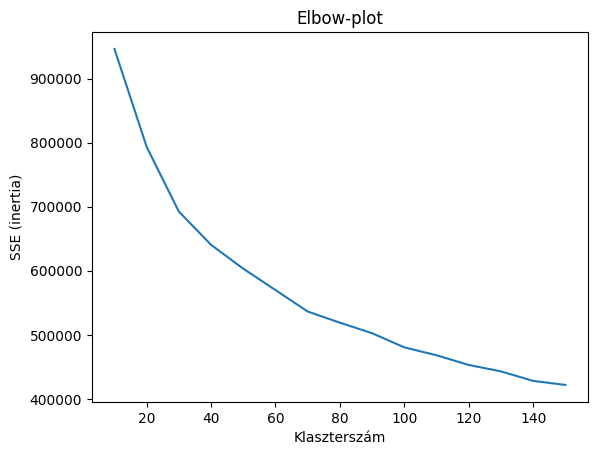

In [120]:
sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
plt.title("Elbow-plot")
plt.xlabel("Klaszterszám")
plt.ylabel("SSE (inertia)")
plt.show()

A grafikon alapján ezeknél a lépésközöknél egyértelműen nem dönthető el, melyik az optimális klaszterszám. Az ábrában $70$-es klaszterszám körül láthatunk egy kis törést, ahonnan a görbe laposodni kezd. Így ezzel a klaszterszámmal is készítünk egy modellt.

In [121]:
# 70 klaszterrel való klaszterezés
kmeans70 = KMeans(n_clusters=70, n_init='auto').fit(X)

A vizualizáció könnyítéséhez és mintázatok kinyeréséhez éredemes lehet egy kis klaszterszámú modellt is tanítani. A $7$ klaszterű modellben jól megfigyelhetjük, hogy a földrajzi komponens (7 kontinens), vagy más tényezők, esetleg együttesen fognak-e dominálni.

In [147]:
# 7 klaszterrel való klaszterezés
kmeans7 = KMeans(n_clusters=7, n_init='auto').fit(X)

### DBSCAN

A DBSCAN algoritmus a távolságmérték helyett a pontok sűrűsége alapján alakít ki klasztereket. Emiatt nincs szüksége klaszterszámra sem, hanem egy minimális pontszámra klaszterenként (`minPts`), valamint a pontok közötti maximális távolságot, hogy még ugyanabba a klaszterbe tartozhassanak (`ε`).

Egy jó heurisztika ezek beállítására, hogy a minimális pontszám legyen a feature-szám, illetve annak duplája közötti. Az epszilon értékhez szintén egy *Elbow-görbét* tudunk felrajzolni. Ezen az összes adatpont, és esetünkben az 500 legközelebbi szomszéd közötti átlagos távolság látható növekvő sorrendben. ε-nak azt az értéket érdemes választani, ahol a görbe legjobban kanyarodik. Ennél nagyobbat választva több pontot fogunk figyelembe venni egy klaszterben, mint indokolt volna a szomszédjai alapján.

A DBSCAN algoritmus előnye az automatikus kalszter méret mellett, hogy képes felismerni az outlier pontokat is, melyek egyik klaszterbe sem tartoznak (nincs elég szomszédjuk hozzá), tehát saját klaszterjüket alkotják. Ugyanakkor nagy hátránya a komplexitása, nagy méretű adathalmazokra alkalmatlannak bizonyulhat.

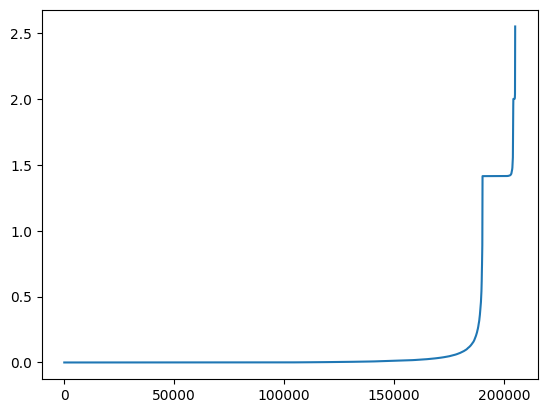

In [123]:
neighbors = NearestNeighbors(n_neighbors=500)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Az Elbow-módszer által jelzett ε-érték esetünkben a $1.5$. Ez azt mutatja, hogy a pontok az adatkeretben közel helyezkednek el egymáshoz. Ezzel konfigurálva tanítjuk a modellt.

In [130]:
dbscan_cluster = DBSCAN(min_samples=500, eps=1.5).fit(X)

### Spectral Clustering (SC)

Az SC algoritmus az adat affinitás mátrixának sajátértékei (spektruma) alapján végez dimenzióredukciót és klaszterezést. A *dask-ml*-es megoldás csak becsli a mátrixot, ezáltal jelentős teljesítményjavulásra tesz szert (a *scikit-learn*-ös megoldáshoz képest, mely egzakt értéket számol).

A klaszterek számát a *KMeans*-hez hasonlóan 20 klaszterre állítottuk be.

In [104]:
sc_cluster = SpectralClustering(n_clusters=20, n_init='auto').fit(X)

Starting check array
Finished check array
A: 80.00 kB, (1, 1) blocks
B: 163.93 MB, (1, 4) blocks
A2: 80.00 kB, (1, 1) blocks
B2: 163.93 MB, (1, 4) blocks
V2.1: 32.80 MB, (5, 1) blocks
V2.2: 32.80 MB, (4, 1) blocks
U2.2: 32.80 MB, (4, 1) blocks
U2.3: 32.80 MB, (203, 1) blocks
Consider persist_embedding. This will require 32.80 MB
k-means for assign_labels[starting]
Starting _check_array
Finished _check_array in 0:00:03.550504
Starting init_scalable
Initializing with k-means||
Starting init iteration  1/13 ,  1 centers
Finished init iteration  1/13 ,  1 centers in 0:00:02.401698
Starting init iteration  2/13 ,  5 centers
Finished init iteration  2/13 ,  5 centers in 0:00:21.247203
Starting init iteration  3/13 ,  7 centers
Finished init iteration  3/13 ,  7 centers in 0:00:02.069626
Starting init iteration  4/13 ,  9 centers
Finished init iteration  4/13 ,  9 centers in 0:00:02.569329
Starting init iteration  5/13 , 11 centers
Finished init iteration  5/13 , 11 centers in 0:00:02.614732


## Modell kiértékelés


Az épített modelleket a földrajzi koordináták szerint ábrázoljuk. Az ábrákon minden egyes pont egy terroresemény a saját klaszter szerint színezve. Ezt végzi el a következő függvény.

In [119]:
def cluster_plot(df, labels, num_labels, title):
    fig, ax = plt.subplots()
    fig.set_size_inches((20, 10))
    fig.suptitle(title)
    scatter = ax.scatter(list(df['longitude']), list(df['latitude']), s=2, c=labels, cmap='tab20b', alpha=1.0)

    # produce a legend with the unique colors from the scatter
    legend = ax.legend(*scatter.legend_elements(num=num_labels), ncol=3,
                        loc="lower left", title="Clusters")
    ax.add_artist(legend)

    plt.show()

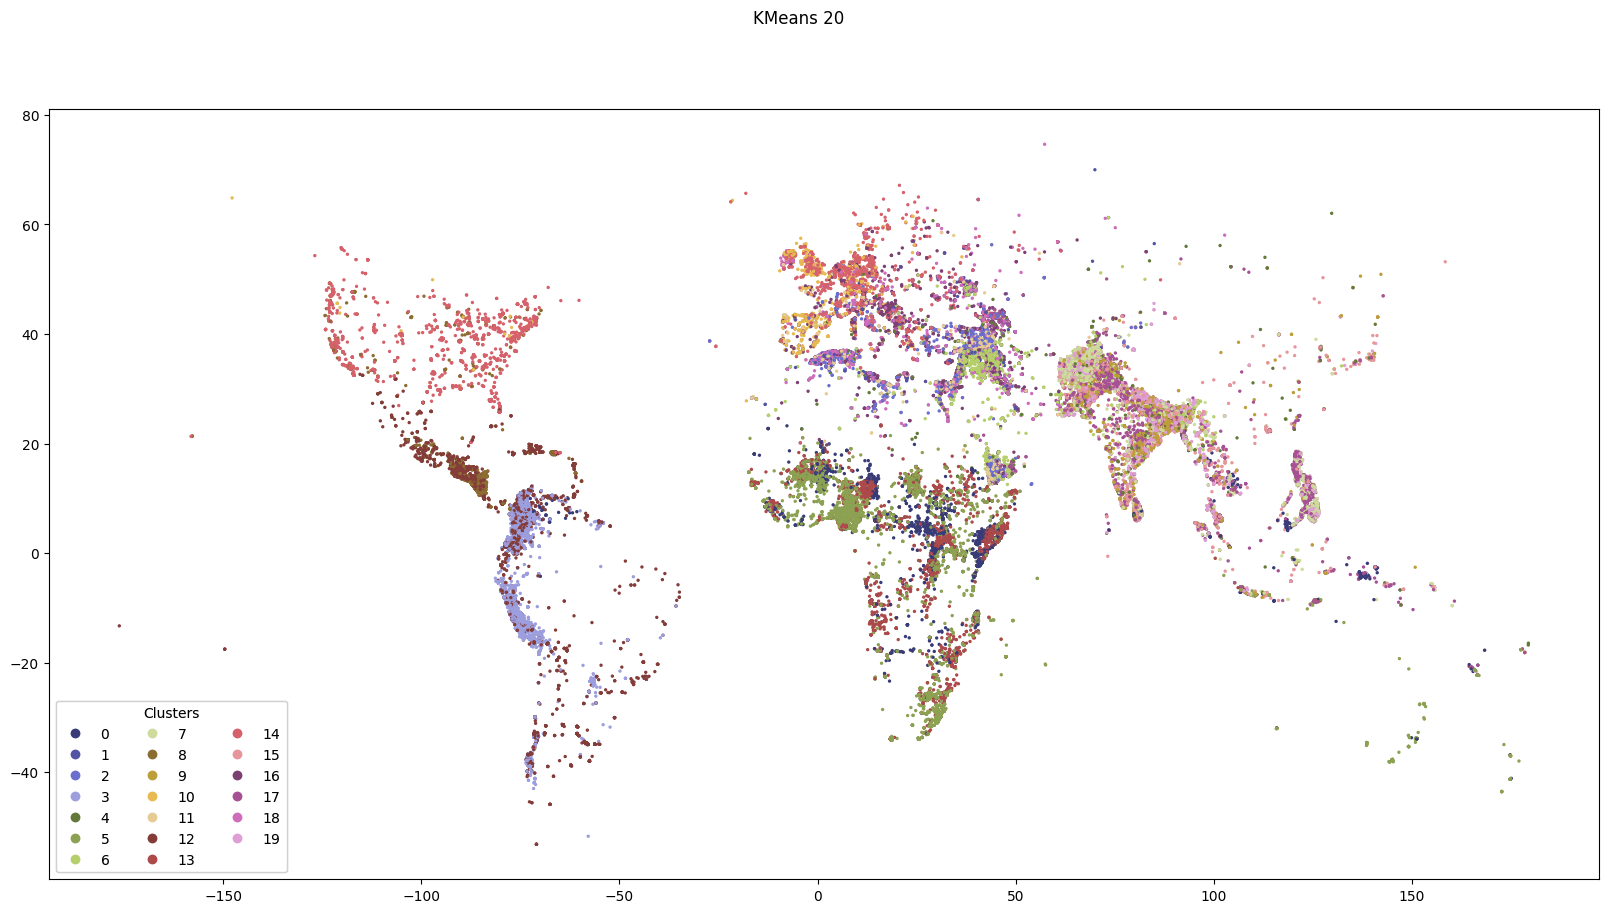

In [137]:
cluster_plot(df_gtd_reduced, kmeans20.labels_, 20, "KMeans 20")

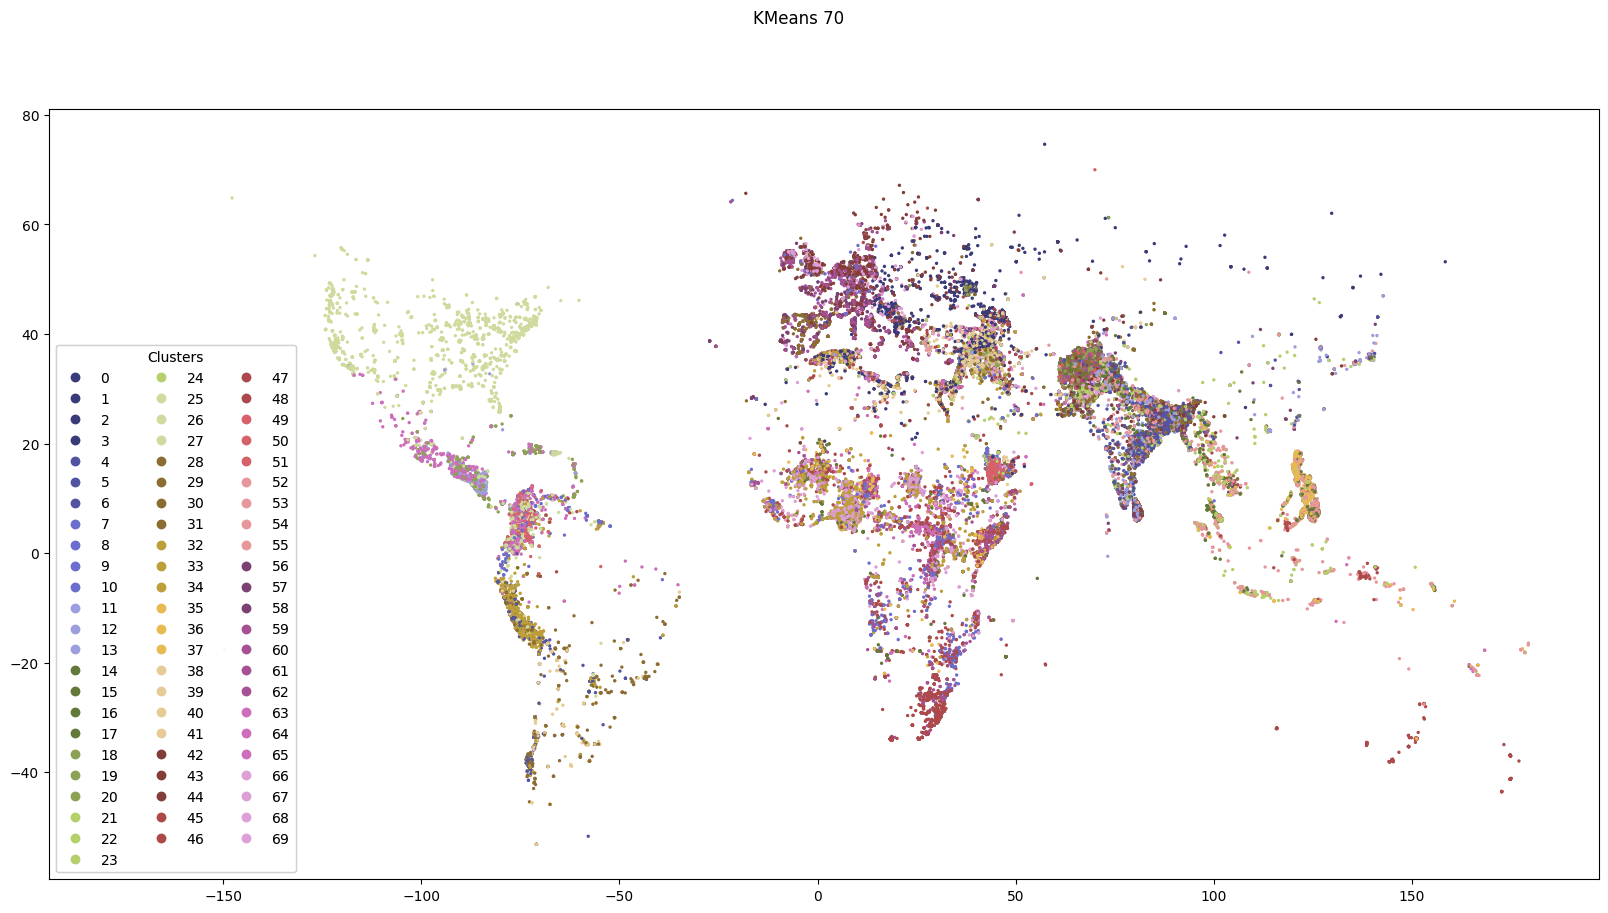

In [138]:
cluster_plot(df_gtd_reduced, kmeans70.labels_, 70, "KMeans 70")

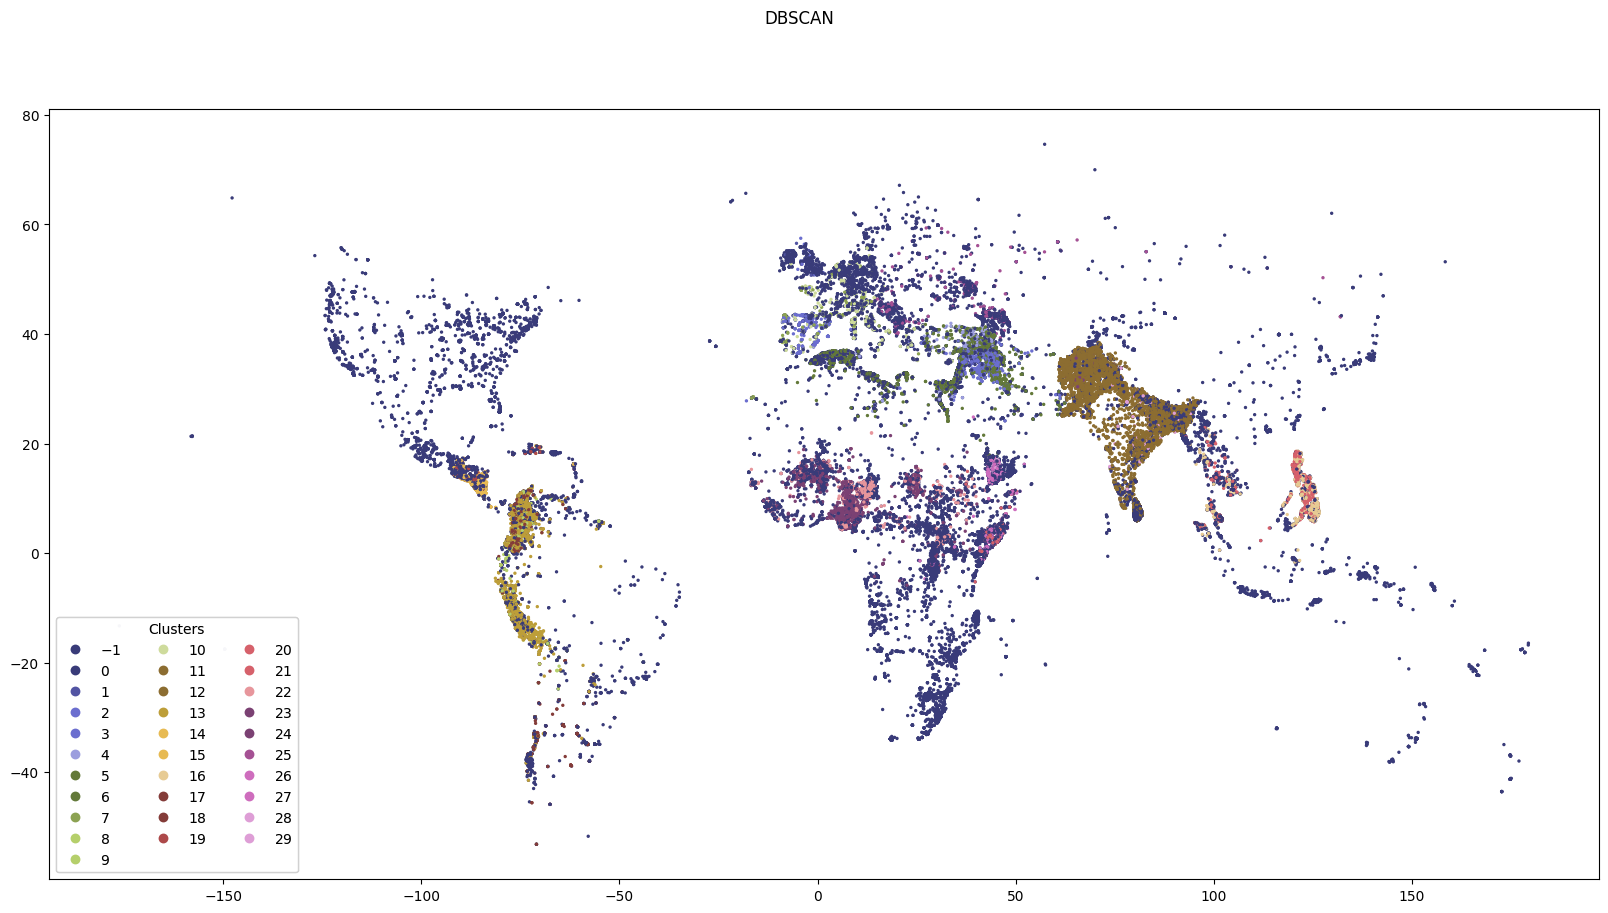

In [139]:
cluster_plot(df_gtd_reduced, dbscan_cluster.labels_, 30, "DBSCAN")

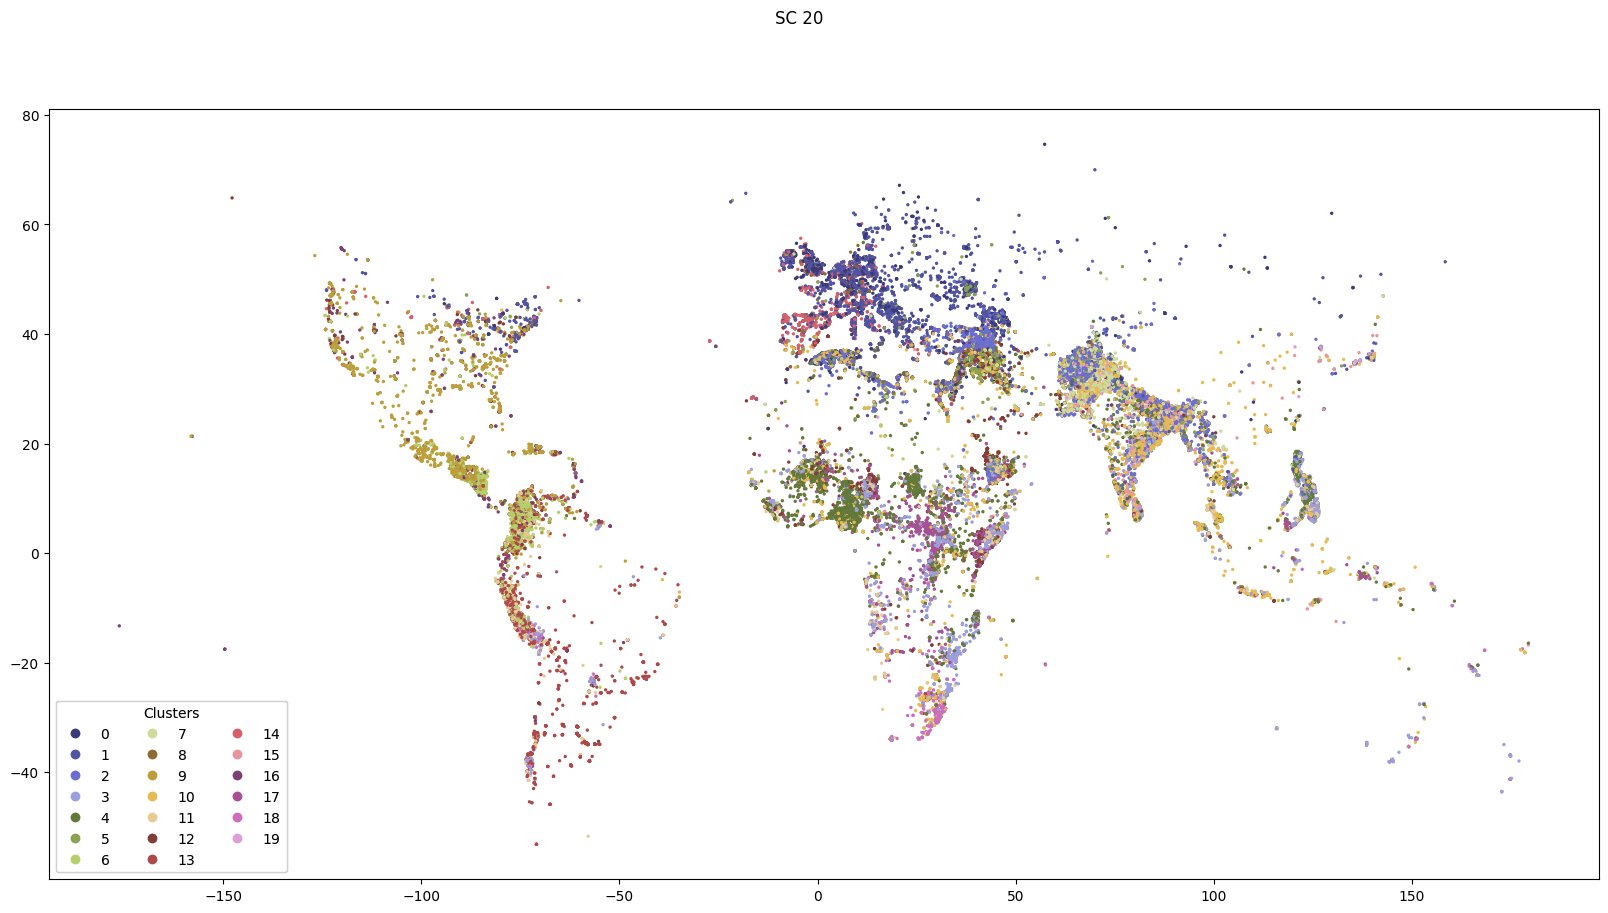

In [140]:
cluster_plot(df_gtd_reduced, sc_cluster.labels_, 20, "SC 20")

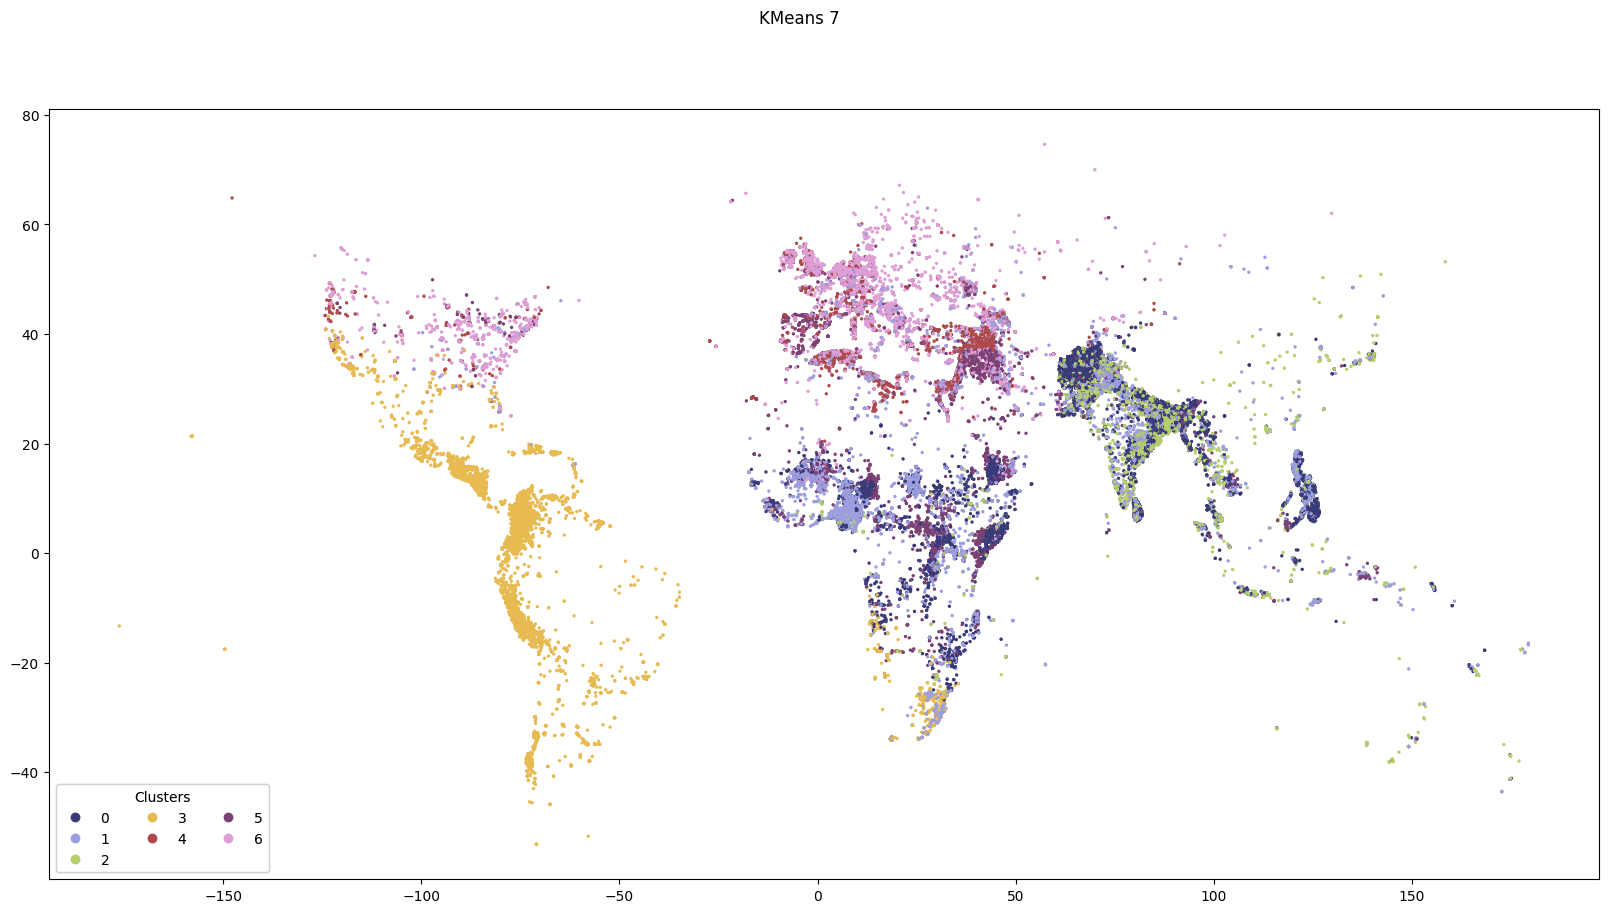

In [155]:
cluster_plot(df_gtd_reduced, kmeans7.labels_, 7, "KMeans 7")

A klaszterek feltérképezése után a következő észrevételeket tehetjük:
* A KMeans esetében noha a 70-es változat optimálisabb klaszterszámot eredményezett a felső Elbow-optimalizás szerint, az áttekinthetőség végett érdemesebb a kisebb klasztert választani
* Mindegyik klaszterezési megoldás esetén jól kivehetően elkülönül néhány ország/térség. Az SC-t és a DBSCAN-t kivéve az Egyesült Államok mindegyik esetben a saját klaszterjét alkotja. Ugyanígy elkülönül az Indiai Szubkontinens (a DBSCAN esetében egy klaszter, a többi esetében több klaszter alkotja). Európában is látható az elosztás. Nyugat-Észak Európa osztozik néhány klaszteren, melyektől a déli országok eltérnek.
* A fenti jelenséget egyrészt a földrajzi koordináták egymáshoz való közelsége, valamint az ország mint bementeti paraméter okozhatja
* A DBSCAN esetében sok outlier pont is van, melyek az elszórtabb terroresemények magyaráznak. Ezen algoritmus klasztereit az sűrűn lakott agglomerációs zónák alkotják (pl. Japán, Közel-Kelet, amerikai, afrikai, illetve európai nagyvárosok). Ezek az agglomerációs zónák a többi térképen is szerepelnek a többi klaszter mellett.
* Talán az egyik legszemléletesebb képet adja a 7 klaszterrel való klaszterezés.
    * Ezen az ábrán már jól látszik, hogy a klaszterekben a földrajzi hely erősen szerepet játszott. Latin-Amerika (plusz a térség más országai) mind ugyanazt a klasztert kapták. Itt az Egyesült Államok már több klaszteren osztozik Európával. Észak-Afrikában szintén az amerikai-európai klaszterek játszottak szerepet. A többi 3 klaszteren pedig Afrika, Ázsia valamint Óceánia osztoztak.
    * Ugyanakkor a földrajzi távolság és az országkódon kívül más tényezők is közrejátszottak. Dél-Afrikában hasonló jellegű bűncselekmények voltak, mint Dél-Ameriában. Különböző afriaki nagyvárosok vonzáskörzete közelségük ellenére más klaszterekbe került. Indiában más volt a támadások jellege a part mentén, mint az ország belsejében.
    * Mindez utalhat az adott országot hasonló bűnüldözésére, kulturájára is. Földrajzilag távolabb eső térségekben hasonló volt a támadások jellege, kimenetele.

---
Az adatok forrása: START (National
Consortium for the Study of Terrorism and Responses to Terrorism). (2022). Global Terrorism Database,
1970 - 2020 [data file]. https://www.start.umd.edu/gtd